In [1]:
import numpy as np
import pandas as pd
import torch
import csv, random
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import RNN, LSTM, GRU, Sigmoid, Linear, Dropout, Module
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, pack_sequence
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable
from sklearn.externals import joblib
import time, math
import json
from datetime import datetime

In [2]:
# data = pd.read_csv('./data/edu_sample.csv')
# data

In [3]:
# data['user_id'] = data['user_id'].astype(str) + "_" + data['area']
# data.to_csv('./data/edu_sample1.csv', index=False)

In [4]:
def read_data(path):
    """
    从文件中读取数据
    :param path: str 文件路径
    :return: int 知识点数量, sequence 原始数据序列
    """
    with open(path, 'r', encoding='UTF-8') as f:
        skill_dt = {}
        skill2name= {}
        seq_dt = {}
        readlines = csv.reader(f)
        for i, readline in enumerate(readlines):
            if i == 0:
                continue
            skill_id = readline[1]
#             skill_name = readline[2]
            user_id = readline[0]
            correct = 1 if readline[5] =='True' else 0
            if skill_id == '' or user_id == '' or correct == '':
                continue
#             if skill_id not in skill2name:    
#                 skill2name[skill_id] = skill_name
            if skill_id not in skill_dt:
                skill_dt[skill_id] = len(skill_dt)
            if user_id in seq_dt:
                seq_dt[user_id].append((skill_dt[(skill_id)], correct))
            else:
                seq_dt[user_id] = [(skill_dt[(skill_id)], correct)]
        seq_dt = {key:value[:1000] for key, value in seq_dt.items() if len(seq_dt[key]) > 2}
        seq_list = list(seq_dt.values())
        return skill_dt, seq_list, skill2name


def split_dataset(seqs, val_rate=0.2, test_rate=0.2):
    """
    将数据拆分为训练集，验证集和测试集
    :param seqs: sequence 原始数据序列
    :param val_rate: float 验证集占总体数据比
    :param test_rate: float 测试集占总体数据比
    :return:
    """
    random.shuffle(seqs)
    seq_size = len(seqs)
    val_size = int(seq_size * val_rate)
    test_size = int(seq_size * test_rate)
    val_seqs = seqs[:val_size]
    test_seqs = seqs[val_size:val_size + test_size]
    train_seqs = seqs[val_size + test_size:]
    return train_seqs, val_seqs, test_seqs

def pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.):
    lengths = [len(s) for s in sequences]
    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((nb_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if len(s) == 0:
            continue  # empty list was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))
        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x


def num_to_one_hot(num, dim):
    base = np.zeros(dim)
    if num >= 0:
        base[num] += 1
    return base

class QuizDataSet(Dataset):

    def __len__(self):
        return len(self._seq_list)

    def __getitem__(self, index):
        return self._seq_list[index]

    def __init__(self, skill_dt, seq_list):
        self._skill_size = len(skill_dt)
        self._seq_list = seq_list


def collate(batch):
    # 压紧序列前需要先排序
    batch.sort(key=lambda x: len(x), reverse=True)
    seq_len = np.array(list(map(lambda seq: len(seq), batch))) - 1
    max_len = max(seq_len) 
    x = pad_sequences(np.array([[(j[0] ) for j in i[:-1]] for i in batch]), maxlen=max_len, padding='post', value=-1)
    x_target = pad_sequences(np.array([[(j[1] ) for j in i[:-1]] for i in batch]), maxlen=max_len, padding='post', value=-1)
#     input_x = np.array([[num_to_one_hot(j, len(skill_dt)*2) for j in i] for i in x])
    input_x = x
    target_id = pad_sequences(np.array([[j[0] for j in i[1:]] for i in batch]), maxlen=max_len, padding='post', value=0)
    target_correctness = pad_sequences(np.array([[j[1] for j in i[1:]] for i in batch]), maxlen=max_len, padding='post', value=0)
    input_x = torch.LongTensor(input_x)
    x_target = torch.Tensor(x_target)
    target_id = torch.Tensor(target_id)
    target_correctness = torch.Tensor(target_correctness)
    return (input_x, x_target), target_id, target_correctness, seq_len, max_len


def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


class DktNet(Module):
    """
    deep knowledge tracing model
    input => rnn => dropout => sigmoid => output
    """

    def __init__(self, skill_size, embedding_size, rnn_h_size, rnn_layer_size, dropout_rate):
        """
        :param skill_size: int 知识点数量
        :param rnn_h_size: int rnn隐藏单元数量
        :param rnn_layer_size: int rnn隐藏层数量
        :param dropout_rate: float
        """
        super(DktNet, self).__init__()
        self.embedding_size = embedding_size
        self.rnn_h_size = rnn_h_size
        embedding_weight = self._load_word2vec('./data/skill_embedding.vec_200d', skill_dt)
        self.embedding = nn.Embedding(skill_size , embedding_size)
        self.embedding.weight = nn.Parameter(embedding_weight, requires_grad=True)
        self.rnn = LSTM(embedding_size + 1, rnn_h_size, rnn_layer_size, dropout =dropout_rate, batch_first=True, bias=True)
        self.dropout = Dropout(p=dropout_rate)
#         self.linear_first = torch.nn.Linear(rnn_h_size,64)
#         self.linear_second = torch.nn.Linear(rnn_h_size,64)
        self.linear_final = Linear(rnn_h_size, skill_size)
        self.sigmoid = Sigmoid()
#         self.weight_init(self.linear_first)
#         self.weight_init(self.linear_second)
        self.weight_init(self.linear_final)
        self.weight_init(self.rnn)
        self.softmax = nn.Softmax(dim=2)
        
    def weight_init(self, m):
        if isinstance(m, nn.LSTM):
            for param in m.parameters():
                if len(param.shape) >= 2:
                    init.orthogonal_(param.data)
                else:
                    init.normal_(param.data)
        elif isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight.data)
            init.normal_(m.bias.data)
        elif isinstance(m, nn.GRU):
            for param in m.parameters():
                if len(param.shape) >= 2:
                    init.orthogonal_(param.data)
                else:
                    init.normal_(param.data)
    def _load_word2vec(self, emb_file, feature_map):
        
        embedding_dict = dict()
        feature_set = set([key for key in feature_map])
        for line in open(emb_file, 'r'):
            line = line.split('\t')
            vector = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))
#             line = line.split('|')
#             vector = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1].split())))
            if line[0] not in feature_set:
                continue
            embedding_dict[line[0]] = vector

        word_vectors = []
        for word in feature_map.keys():

            if word in embedding_dict.keys():
                vector = embedding_dict[word]
            else:
                vector = np.random.normal(scale=0.2, size=self.embedding_size)  # random vector

            word_vectors.append(vector)

        weight = np.stack(word_vectors)
        return torch.Tensor(weight)
    
    def forward(self, input_data, target_id, sequence_len, max_steps):
        input_x, x_target = input_data
        embedded = self.embedding(input_x.cuda())
        embedded = torch.cat((embedded, x_target.cuda().unsqueeze(-1)), -1)
#         mask = input_data.ne(0.).unsqueeze(-2).type_as(input_data.data)
#         mask = mask & Variable(
#             subsequent_mask(input_data.size(-1)).type_as(input_data.data))
        input_data = torch.nn.utils.rnn.pack_padded_sequence(embedded, sequence_len, batch_first=True)
        state, h = self.rnn(input_data)
        state, lengths = torch.nn.utils.rnn.pad_packed_sequence(state, batch_first=True)  # (sequence, lengths)
        # rnn_output无需保留序列结构数据，直接用rnn_output.data
        state = self.dropout(state)
#         q = self.linear_first(state) 
#         k = self.linear_second(state)          
#         attn = torch.bmm(q, k.transpose(1, 2))/ np.power(64, 0.5)
#         attn = attn.masked_fill(mask == 0, -1e9)
#         attn = self.softmax(attn)
#         output = torch.bmm(attn, state)
        logits = self.linear_final(state)
        pred_all = self.sigmoid(logits)
        flat_logits = logits.view(-1)
        flat_base_target_index = torch.arange(state.size(0) * max_steps * 1.0) * len(skill_dt)
        flat_bias_target_id = target_id.view(-1)
        flat_target_id = flat_bias_target_id + flat_base_target_index
        flat_target_logits = torch.index_select(flat_logits, 0, flat_target_id.long().cuda())
        del input_data, h, flat_target_id, logits
        pred = self.sigmoid(flat_target_logits.view(state.size(0), max_steps))
        return state.cpu(), pred.cpu(), flat_target_logits, pred_all


def add_gradient_noise(model, idx_batch, epoch, number_minibatches_per_epoch):
    # Adding random gaussian noise as in the paper "Adding gradient noise improves learning
    # for very deep networks"

    for p in model.parameters():
        gaussianNoise = torch.Tensor(p.grad.size()).cuda()
        # here nu = 0.01, gamma = 0.55, t is the minibatch count = epoch*total_length +idx_minibatch
        stdDev = (0.01 / (1 + epoch * number_minibatches_per_epoch + idx_batch) ** 0.55) ** 0.5
        gaussianNoise.normal_(0, std=stdDev)
        p.grad.data.add_(gaussianNoise)


In [5]:
# rnn隐藏单元数量
HIDDEN_SIZE = 200
EMBEDDING_SIZE = 200
# rnn隐藏层数量
HIDDEN_LAYER_SIZE = 1
DROPOUT_RATE = 0.6
EPOCHS = 10
BATCH_SIZE = 16

skill_dt, seq_list, skill2name = read_data('./data/edu_sample1.csv')
train_seqs, val_seqs, test_seqs = split_dataset(seq_list)
train_dataset = QuizDataSet(skill_dt, train_seqs)
val_dataset = QuizDataSet(skill_dt, val_seqs)
model = DktNet(len(skill_dt), EMBEDDING_SIZE, HIDDEN_SIZE, HIDDEN_LAYER_SIZE, DROPOUT_RATE)
criterion = torch.nn.BCEWithLogitsLoss(size_average=False)
# criterion = torch.nn.NLLLoss( size_average=False)
model = model.cuda()
criterion = criterion.cuda()
trainable_params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params=trainable_params, lr=0.001)
optimizer = torch.optim.RMSprop(params=trainable_params)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1 / 1.00004)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, drop_last=True)
val_data_loader = DataLoader(val_dataset, collate_fn=collate, batch_size=BATCH_SIZE, drop_last=True)

d:\anaconda3\envs\deeplearning\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
max_val_auc = 0
for i in range(EPOCHS):
    preds, binary_preds, targets = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
    for j, batched in enumerate(train_data_loader):
        scheduler.step()
        input_data, target_id, target_correctness, sequence_len, max_steps = batched
        optimizer.zero_grad()
        _, pred, logits, _  = model(input_data, target_id, sequence_len, max_steps)  
        flat_target_correctness = target_correctness.view(-1)
        binary_pred = torch.gt(pred, 0.5)
        loss = criterion(logits, flat_target_correctness.cuda())
        
        if j % 50 == 0:
            print('epoch: {0}, step: {1}, loss: {2}'.format(i + 1, j + 1, loss.item()))
        loss.backward()
#         torch.nn.utils.clip_grad_norm(model.parameters(), 4)

        add_gradient_noise(model, j, i, len(train_data_loader))
#         gradient clipping
        for p in model.parameters():
            p.grad = p.grad.clamp(min=-5, max=5)
            
        optimizer.step()
        for seq_idx, seq_len in enumerate(sequence_len):
            preds = torch.cat((preds, pred[seq_idx, 0:seq_len].cpu()))
            binary_preds = torch.cat((binary_preds, binary_pred[seq_idx, 0:seq_len].float().cpu()))
            targets = torch.cat((targets, target_correctness[seq_idx, 0:seq_len].cpu()))
    with torch.no_grad():
        # compute metrics
        preds = preds.detach().numpy()
        binary_preds = binary_preds.detach().numpy()
        targets = targets.detach().numpy()
        auc_value = roc_auc_score(targets, preds)
        accuracy = accuracy_score(targets, binary_preds)
        precision, recall, f_score, _ = precision_recall_fscore_support(targets, binary_preds)
        print("\n auc={0}, accuracy={1}, precision={2}, recall={3}, f_score={4}".format(auc_value, accuracy, precision, recall,f_score ))
        if auc_value > max_val_auc:
            max_val_auc = auc_value
        else:
            print('reduce learning rate by multiply 0.7')
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.5

epoch: 1, step: 1, loss: 2984.589111328125
epoch: 1, step: 51, loss: 313.5374755859375
epoch: 1, step: 101, loss: 268.7160949707031
epoch: 1, step: 151, loss: 248.77821350097656
epoch: 1, step: 201, loss: 573.7098999023438
epoch: 1, step: 251, loss: 469.290771484375
epoch: 1, step: 301, loss: 882.7134399414062
epoch: 1, step: 351, loss: 228.49620056152344
epoch: 1, step: 401, loss: 1677.987548828125

 auc=0.6857083549569754, accuracy=0.812911867228363, precision=[0.39546851 0.84310882], recall=[0.15421872 0.95068948], f_score=[0.22190308 0.89367315]
epoch: 2, step: 1, loss: 564.4609375
epoch: 2, step: 51, loss: 736.243408203125
epoch: 2, step: 101, loss: 220.6787109375
epoch: 2, step: 151, loss: 678.2443237304688
epoch: 2, step: 201, loss: 618.4981079101562
epoch: 2, step: 251, loss: 1784.8116455078125
epoch: 2, step: 301, loss: 239.92807006835938
epoch: 2, step: 351, loss: 1013.0369262695312
epoch: 2, step: 401, loss: 1594.9110107421875

 auc=0.7285966912646957, accuracy=0.82839252305

In [7]:
torch.save(model, './chk/dkt.model')

d:\anaconda3\envs\deeplearning\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type DktNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
data = pd.read_csv('./data/edu_sample.csv')
data = data[['prerequisites','exercise']].drop_duplicates().fillna(' ')
data[data['exercise'] == 'supplementary_angles']['prerequisites'].values

array(['angle_types'], dtype=object)

In [9]:
data = pd.read_csv('./data/edu_sample.csv')[[ 'exercise', 'prerequisites','topic', 'area']]

data1 = data[['exercise','prerequisites']].drop_duplicates().dropna().rename(columns={'prerequisites':'target'}).reset_index(drop=True)
data1 = pd.DataFrame(data1.target.str.split(',').tolist(), index=data1.exercise).stack()
data1 = data1.reset_index()[[0, 'exercise']] # var1 variable is currently labeled 0
data1.columns = ['target', 'exercise']
data1['relation'] = 'prerequisite'
data2 = data[['exercise','topic']].drop_duplicates().dropna().rename(columns={'topic':'target'}).reset_index(drop=True)
data2['relation'] = 'is_topic_of'
data3 = data[['exercise','area']].drop_duplicates().dropna().rename(columns={'area':'target'}).reset_index(drop=True)
data3['relation'] = 'is_area_of'

In [10]:
pd.concat([data1, data2, data3]).reset_index(drop=True).to_csv('./data/relation.csv', index=False)

d:\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [11]:
data.columns

Index(['exercise', 'prerequisites', 'topic', 'area'], dtype='object')

In [12]:
test = [[(0, 1), (29, 1), (6, 1), (12, 1), (1, 1), (2, 1), (4, 1), (64, 1), (143, 1), (265, 1), (48, 1)]] * BATCH_SIZE

In [13]:
test1 = [[(0, 0), (29, 0), (6, 0), (12, 0), (1, 0), (2, 0), (4, 0), (64, 0), (143, 0), (265, 0), (48, 0)]] * BATCH_SIZE

In [14]:
problem_dict = {v:k for k,v in skill_dt.items()}

In [15]:
[problem_dict[x[0]] for x in test[0]]

['number_line',
 'understand_coins',
 'addition_1',
 'addition_2',
 'multiplication_0.5',
 'multiplication_1',
 'multiplication_1.5',
 'multiplication_2',
 'division_3',
 'division_4',
 'dividing_decimals_1']

In [16]:
torch.cuda.empty_cache()

In [18]:
test_dataset1 = QuizDataSet(skill_dt, test1)
test_data_loader1 = DataLoader(test_dataset1, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, drop_last=True)
output1, hidden1 = [], []
for j, batched in enumerate(test_data_loader1):
    input_data, target_id, target_correctness, sequence_len, max_steps = batched
    state, pred, logits, pred_all = model(input_data, target_id, sequence_len, max_steps)
    hidden1.append(state)
    output1.append(pred_all)

In [21]:
test_dataset = QuizDataSet(skill_dt, test)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, drop_last=True)
output, hidden = [], []
for j, batched in enumerate(test_data_loader):
    input_data, target_id, target_correctness, sequence_len, max_steps = batched
    state, pred, logits, pred_all = model(input_data, target_id, sequence_len, max_steps)
    hidden.append(state)
    output.append(pred_all)

In [22]:
selected_skill = [0, 29, 6, 12, 1, 2, 4, 64, 143, 265, 48, 3, 324, 125, 144, 32,  30, 328, 31, 5, 327, 66, 39, 326, 67, 62, 28, 467, 544, 620, 660, 636, 613, 571, 478, 454]

In [23]:
emb = None
for name, param in model.named_parameters():
    if 'embedding' in name:
        emb = (param.cpu().detach().numpy())

In [24]:
labels = []
tokens = []
for i in range(emb.shape[0]):
    labels.append(problem_dict[i])
    tokens.append(emb[i])

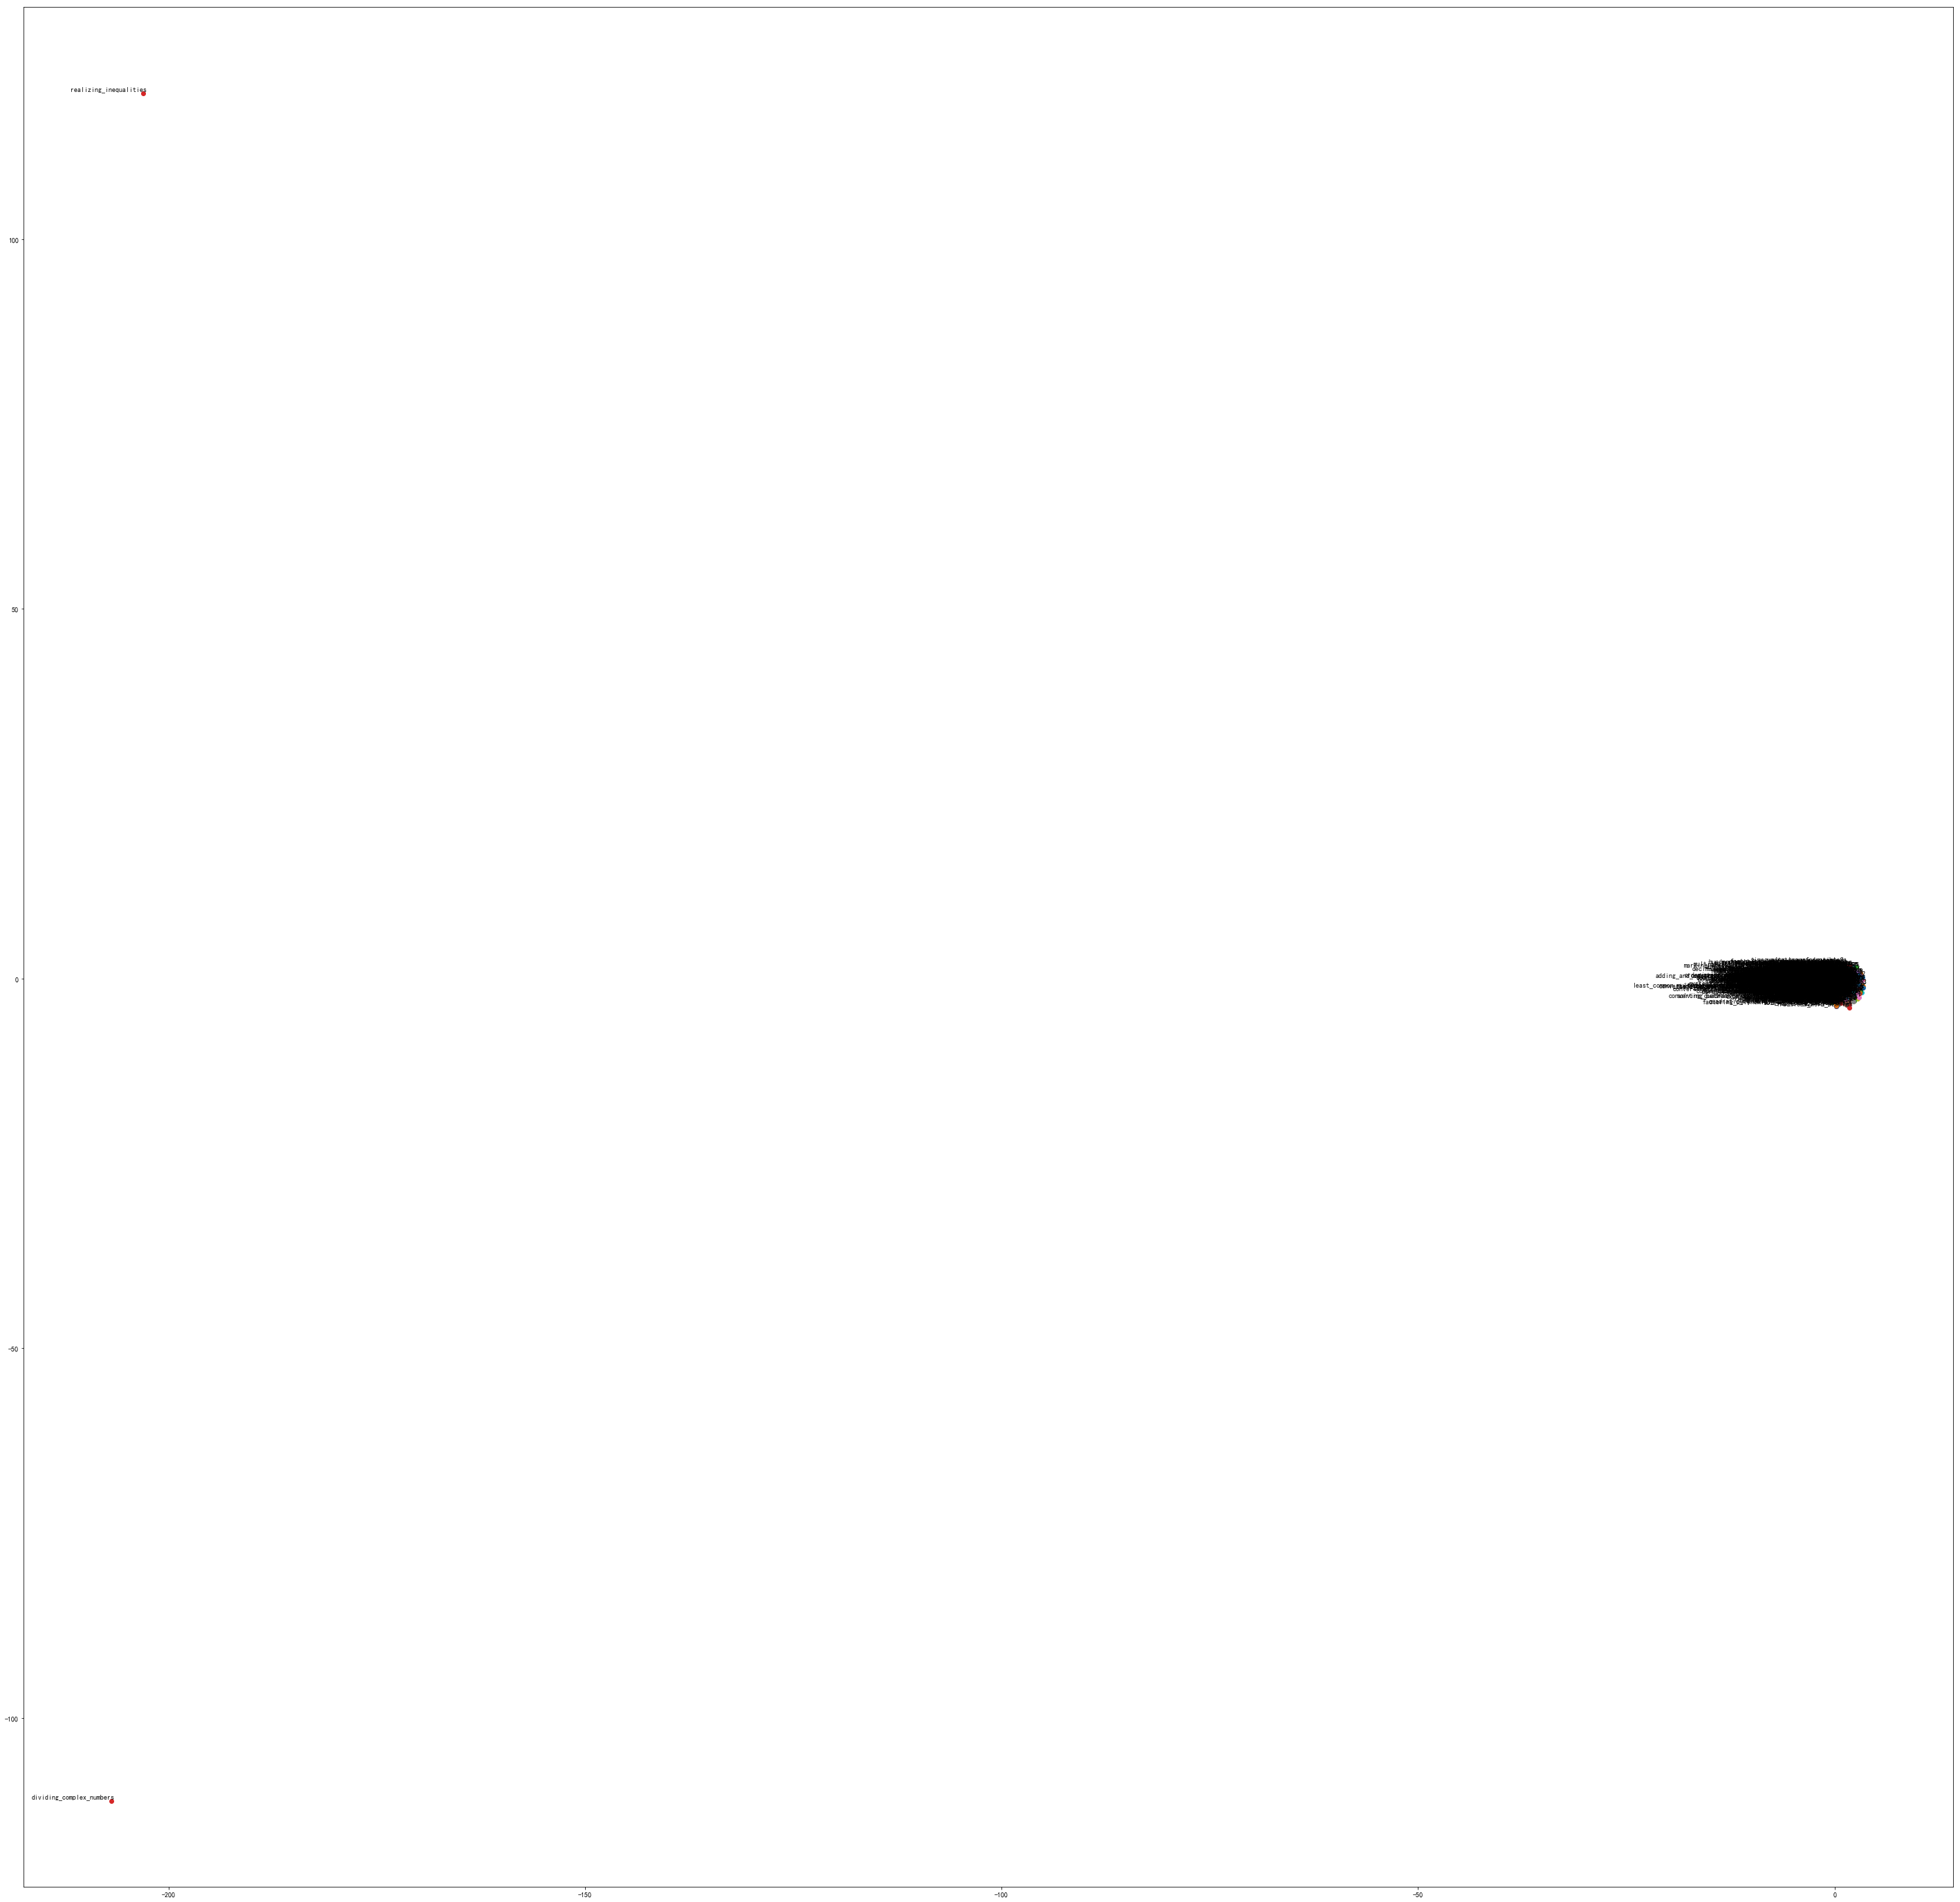

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

def tsne_plot(tokens, labels):
    "Creates and TSNE model and plots it"    
    tsne_model = TSNE(n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(50, 50)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(tokens, labels)

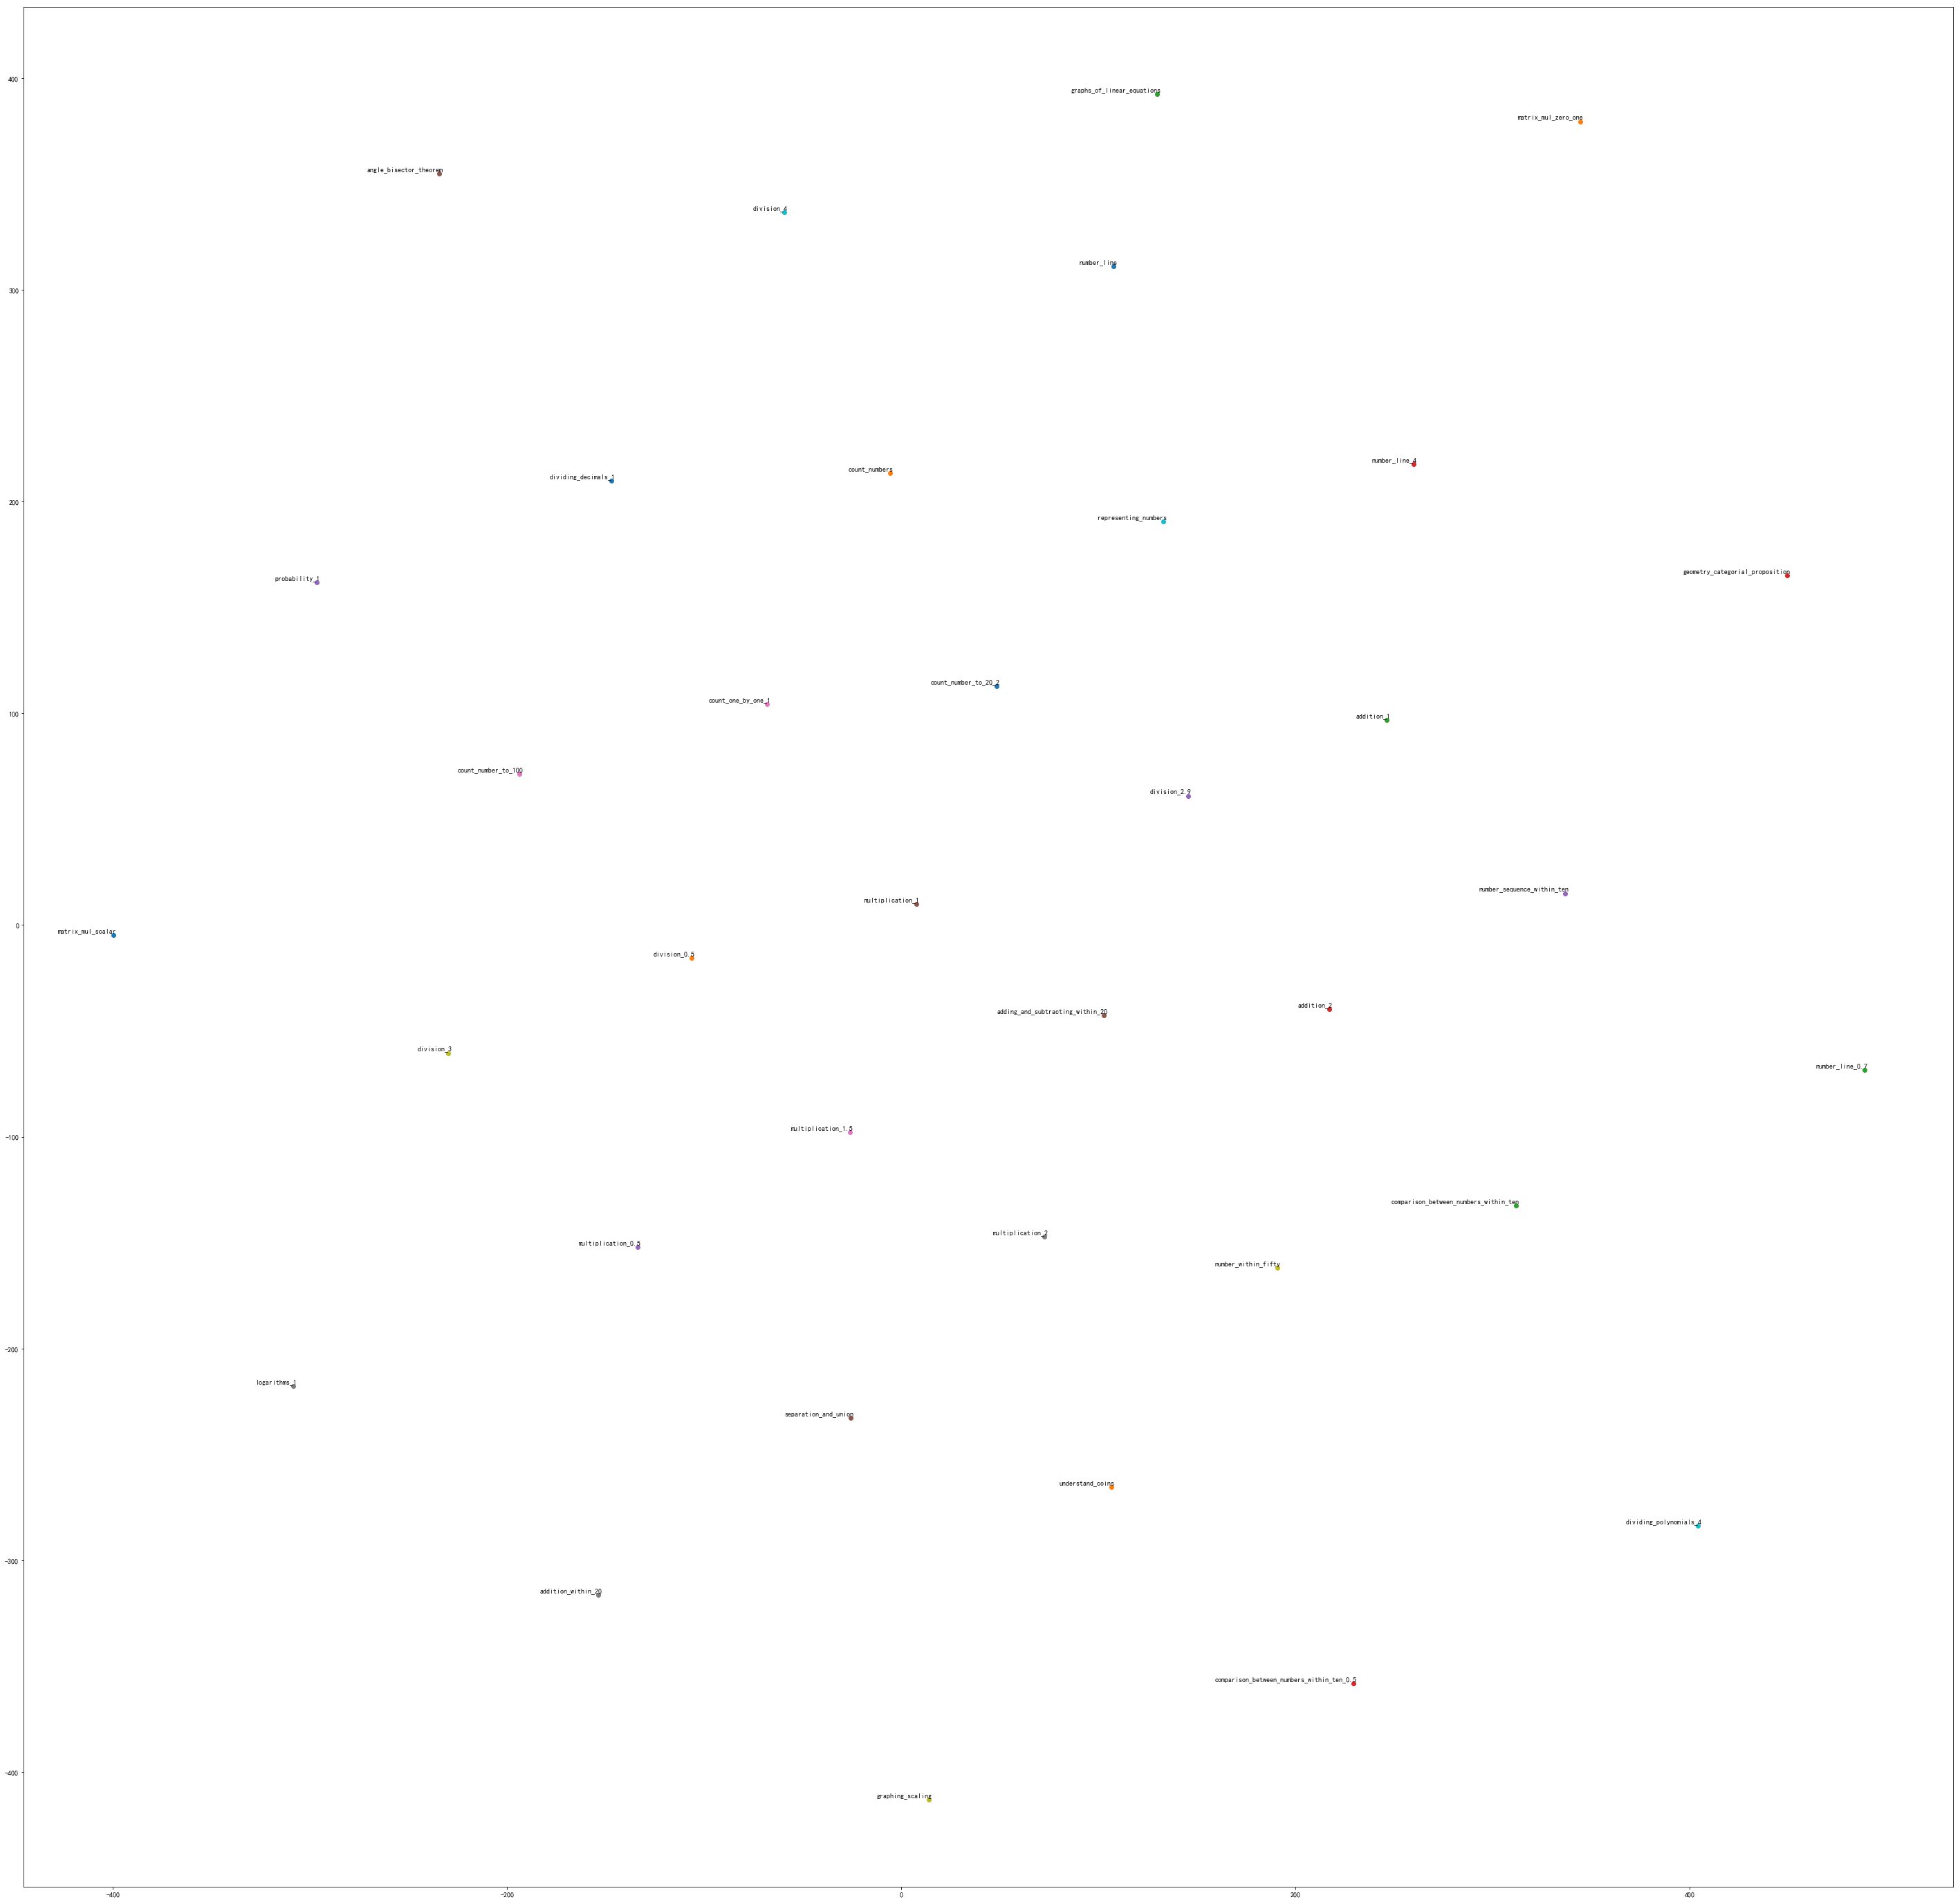

In [26]:
labels1 = []
tokens1 = []
for i in selected_skill:
    labels1.append(problem_dict[i])
    tokens1.append(emb[i])
    
tsne_plot(tokens1, labels1)

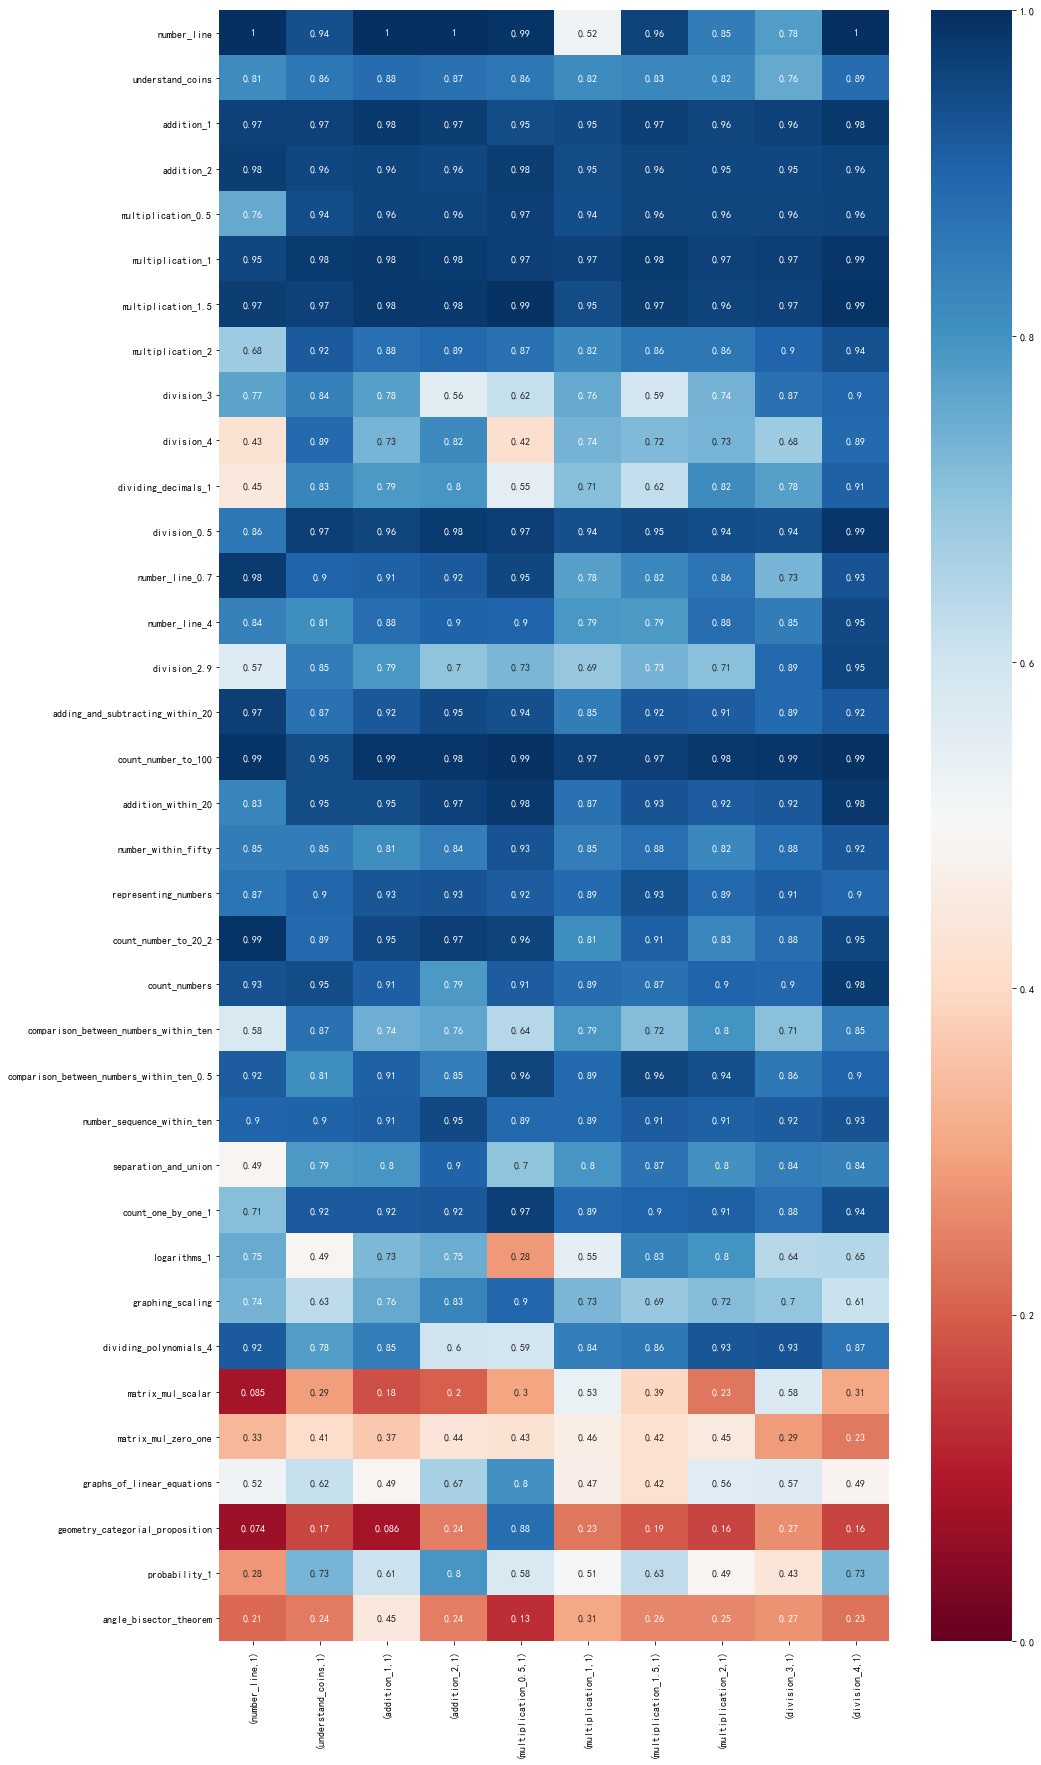

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 30))
df4 = pd.DataFrame(output[0][0][:, selected_skill].data.detach().cpu().numpy())
df4.columns = [problem_dict[x] for x in selected_skill]
df4.index = ["({},{})".format(problem_dict[p], c) for p, c in test[0][:-1]]
sns.heatmap(df4.T,cmap='RdBu', vmax=1, vmin=0, annot=True)


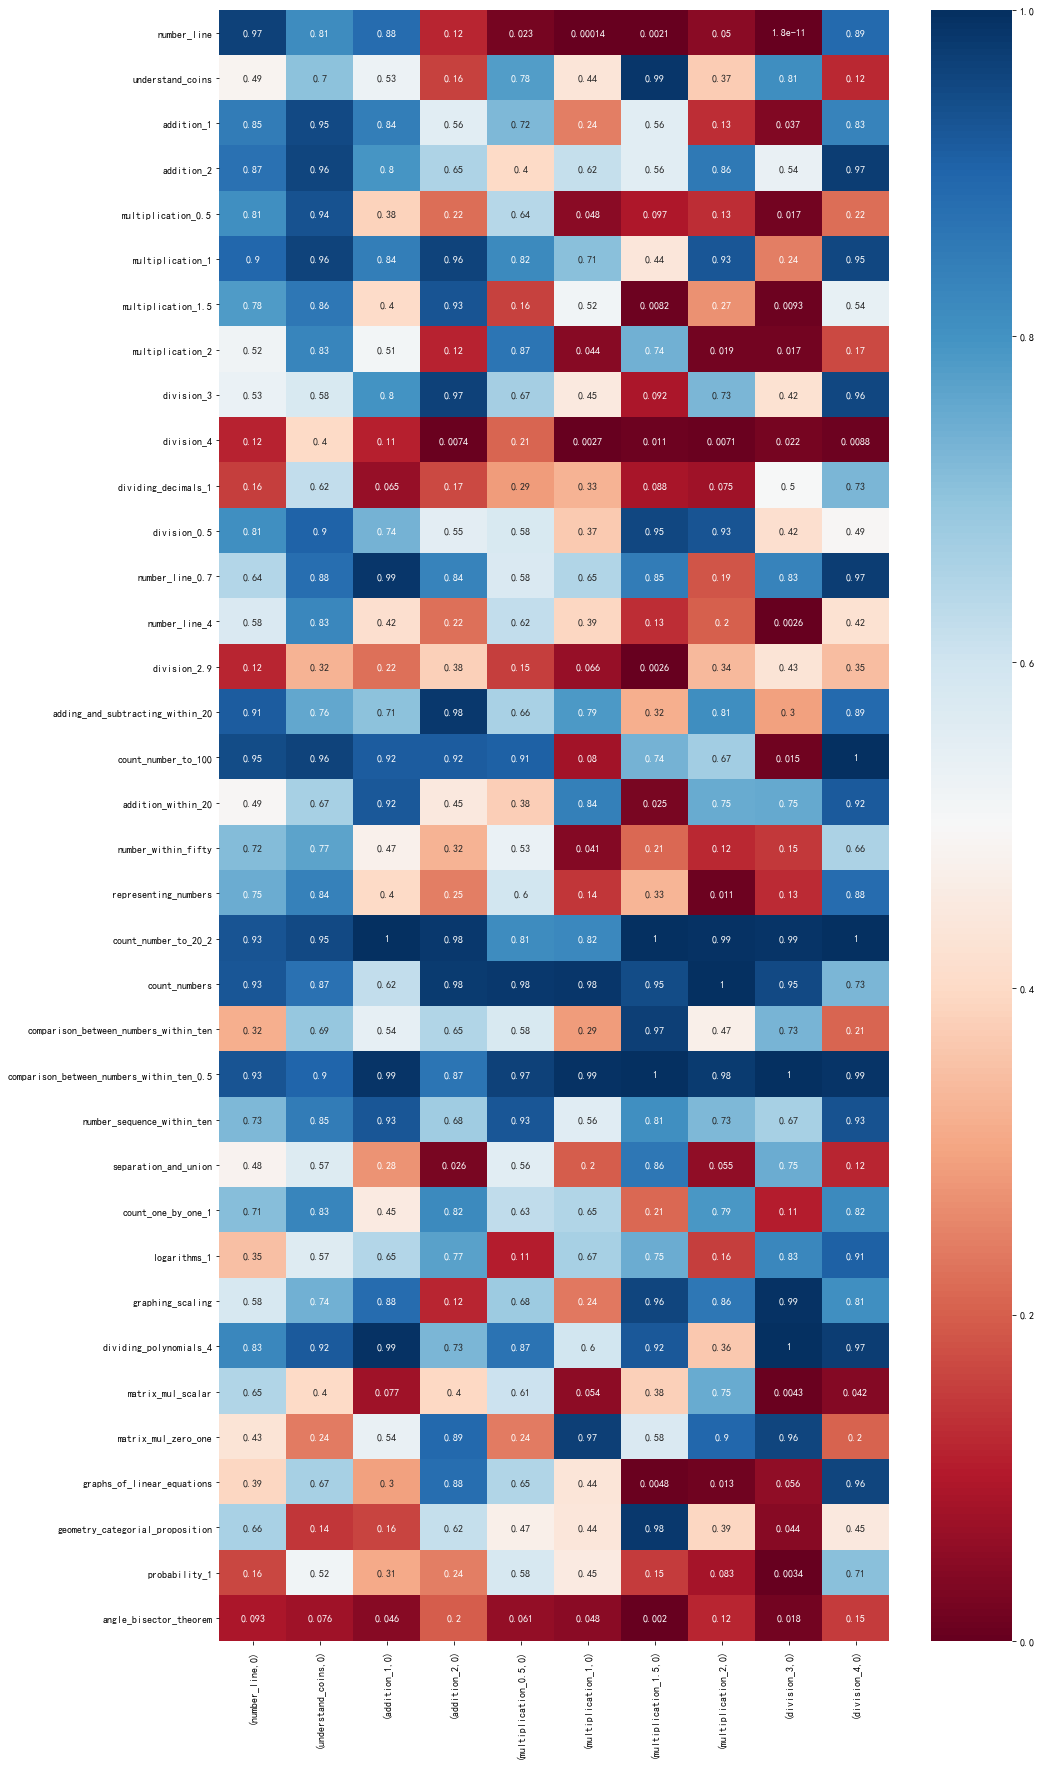

In [28]:
plt.figure(figsize=(15, 30))
df3 = pd.DataFrame(output1[0][0][:, selected_skill].data.detach().cpu().numpy())
df3.columns = [problem_dict[x] for x in selected_skill]
df3.index = ["({},{})".format(problem_dict[p], c) for p, c in test1[0][:-1]]
sns.heatmap(df3.T, cmap='RdBu', vmax=1, vmin=0, annot=True)

Text(68.7344,0.5,'hidden')

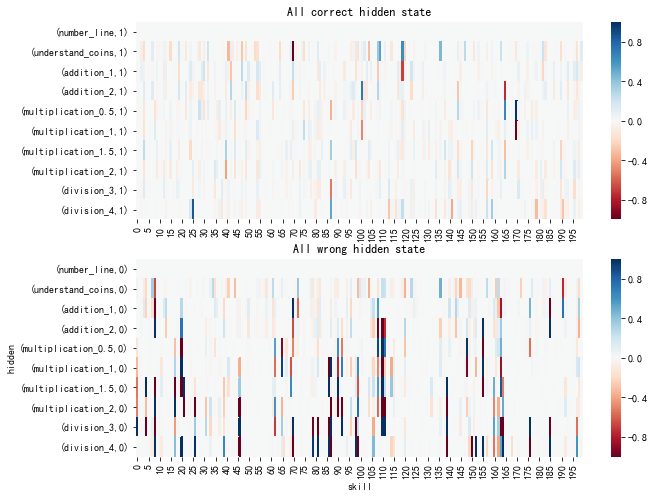

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
f, (ax1,ax2) = plt.subplots(figsize = (10, 8),nrows=2)
df2 = pd.DataFrame(hidden[0][0].data.detach().cpu().numpy())
df2.index = ["({},{})".format(problem_dict[p], c) for p, c in test[0][:-1]]
ax1.set_title('All correct hidden state')
ax1.set_xlabel('')
ax1.set_xticklabels([]) #设置x轴图例为空值
ax1.set_ylabel('kind')
sns.heatmap(df2.diff(axis=0).fillna(0.0), cmap='RdBu', vmax=1, vmin=-1,ax=ax1)
df1 = pd.DataFrame(hidden1[0][0].data.detach().cpu().numpy())
df1.index = ["({},{})".format(problem_dict[p], c) for p, c in test1[0][:-1]]
sns.heatmap(df1.diff(axis=0).fillna(0.0), cmap='RdBu', vmax=1, vmin=-1,ax=ax2)

ax2.set_title('All wrong hidden state')
ax2.set_xlabel('skill')
ax2.set_ylabel('hidden')


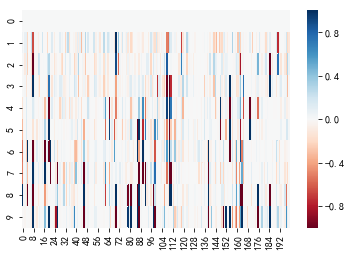

In [30]:
sns.heatmap(pd.DataFrame(df1.diff(axis=0).fillna(0.0).values - df2.diff(axis=0).fillna(0.0).values), cmap='RdBu', vmax=1, vmin=-1)

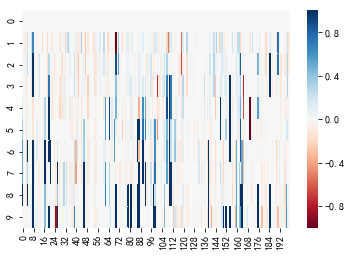

In [31]:
sns.heatmap(df1.diff(axis=0).fillna(0.0).abs().values-df2.diff(axis=0).fillna(0.0).abs().values, cmap='RdBu', vmax=1, vmin=-1)

In [ ]:
from math import pi
import pandas as pd

from bokeh.io import show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, BasicTicker, PrintfTickFormatter,ColorBar
from bokeh.models import FuncTickFormatter
from bokeh.plotting import figure

data = pd.read_csv('paran-data-df.csv', index_col=0)
data = data.T
data.index.name = 'cell'
data.columns.name = 'chars'


In [ ]:
data2 = data.diff(axis=1).fillna(0.0)

In [ ]:
%matplotlib inline


In [ ]:
from bokeh.io import output_notebook
from bokeh.models import LogColorMapper, LogTicker, ColorBar
output_notebook()

In [ ]:
index = {i:problem_dict[inputs[i][0]] for i in range(len(data.columns))}

seq = [str(i) for i in data.columns]
cell = list([str(x) for x in data.index])

df = pd.DataFrame(data.stack(), columns=['value']).reset_index()
colors = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]

colors.reverse()
mapper = LinearColorMapper(palette=colors, low=-1, high=1)#low=df.value.min(), high=df.value.max())
source = ColumnDataSource(df)
TOOLS = "hover,pan,reset,save,wheel_zoom"

color_bar = ColorBar(color_mapper=mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p = figure(title="LSTM Hidden State Activations",  x_range=cell, y_range=list(reversed(seq)), x_axis_location="above",
            plot_width=500, plot_height=300,
            tools=TOOLS, toolbar_location='below')

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "8pt"
p.axis.major_label_standoff = 0
p.yaxis.major_label_orientation = pi / 3
p.yaxis.formatter = FuncTickFormatter(code="""
                                        var labels = %s;
                                        return labels[tick];
                                    """%index)

p.rect(x="cell", y="chars", width=1, height=1, source=source, fill_color={'field': 'value', 'transform': mapper},
                                line_color=None)

p.select_one(HoverTool).tooltips = [('value', '@value')]
p.add_layout(color_bar, 'right')
show(p)      # show the plot

In [ ]:
index = {i:problem_dict[inputs[i][0]] for i in range(len(data2.columns))}

seq = [str(i) for i in data2.columns]
cell = list(data2.index)

df = pd.DataFrame(data2.stack(), columns=['value']).reset_index()
colors = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]

colors.reverse()
mapper = LinearColorMapper(palette=colors, low=-1, high=1)#low=df.value.min(), high=df.value.max())
source = ColumnDataSource(df)
TOOLS = "hover,pan,reset,save,wheel_zoom"

color_bar = ColorBar(color_mapper=mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p = figure(title="LSTM Hidden State Activations",  x_range=seq, y_range=list(reversed(cell)), x_axis_location="above",
            plot_width=300, plot_height=500,
            tools=TOOLS, toolbar_location='below')

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "8pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3
p.xaxis.formatter = FuncTickFormatter(code="""
                                        var labels = %s;
                                        return labels[tick];
                                    """%index)

p.rect(x="chars", y="cell", width=1, height=1, source=source, fill_color={'field': 'value', 'transform': mapper},
                                line_color=None)

p.select_one(HoverTool).tooltips = [('value', '@value')]
p.add_layout(color_bar, 'right')
show(p)      # show the plot

# 